In [1]:
import pandas as pd
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import re
from string import punctuation
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import community as community_louvain
import networkx as nx
from fa2 import ForceAtlas2
from collections import defaultdict
from nltk.corpus import wordnet as wn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns

<p style="font-family:Muro;font-weight:bold;font-size:35px;margin:10px 0px 10px 0px;color:#ADD8E6">Communities</p>

Here we will look at the implicit communities within the network. We will then try to make sense out of the resulting groupings (or not) with what we actually observe throughout the series. 

We will use the [Louvain method](https://en.wikipedia.org/wiki/Louvain_method) to detect communities within the larger network. This algorithm is a [hierarchical clustering algorithm](https://neo4j.com/docs/graph-data-science/current/algorithms/louvain/), that recursively merges smaller communities in order to maximize the modularity score, which measures how densely connected the nodes are within the same community.

In [2]:
G = nx.readwrite.adjlist.read_adjlist("Data/GCC.gz")

In [3]:
#Using the .best_partition method of the louvain algorithm, randomize is set to false so the results stay uniform
partition = community_louvain.best_partition(G, randomize=False)

#Counting the amount of communities
count = len(set(partition.values()))

#As well as the modularity
modu = community_louvain.modularity(partition, G)

#Printing out the answers to these two questions.
print(f"We found {count} communities in total.")
print(f"The modularity of the partition created is {modu}.")

We found 12 communities in total.
The modularity of the partition created is 0.48907502838675865.


In [4]:
communities = defaultdict(list)

# Group characters into their communities 
for character, community in zip(partition.keys(),partition.values()):
    communities[community].append(character)

In [5]:
named_communities = {}

for community in communities.values():
    sorted_com = sorted(community, key = lambda x : G.degree[x], reverse = True)
    name = ", ".join(sorted_com[:3]).replace("_", " ")
    print("----------")
    print(f"Community of {name}:")
    print(f"Has {len(sorted_com)} members")
    print("----------")
    for character in sorted_com[:10]:
        print(character.replace("_", " "))
    print()

----------
Community of Andy Bernard, List of IT guys, Walter Bernard Jr.:
Has 13 members
----------
Andy Bernard
List of IT guys
Walter Bernard Jr.
Walter Bernard Sr.
Ellen Bernard
Nick
Sadiq
Cathy Simms
Tiffany
Unnamed Cousin

----------
Community of Ryan Howard, Erin Hannon, Nellie Bertram:
Has 20 members
----------
Ryan Howard
Erin Hannon
Nellie Bertram
List of aliases
Meredith Palmer
Robert Dunder
The Gypsy
Erin's Mother
Erin's Father
Irene

----------
Community of Dwight Schrute, Angela Martin, Oscar Martinez:
Has 28 members
----------
Dwight Schrute
Angela Martin
Oscar Martinez
Robert Lipton
Mose Schrute
Pizza Delivery Kid
Garbage
Aunt Shirley
Phillip Schrute
Isabel Poreba

----------
Community of Jim Halpert, Pam Beesly, Cecelia Halpert:
Has 17 members
----------
Jim Halpert
Pam Beesly
Cecelia Halpert
Phillip Halpert
Helene Beesly
Betsy Halpert
William Beesly
Gerald Halpert
Penny Beesly
Sylvia

----------
Community of Robert California, Toby Flenderson, Gabe Lewis:
Has 22 membe

We notice a clear trend where romantic partners and families are placed together, including Michael and Holly in 1, Phyllis and Bob in 9, and Andy's and Erin's families in 1 and 2 respectively, amongst others. 

While many minor characters seem to be placed with some randomness, there are also some significant characters that didn't seem to have an obvious bond with the rest of the characters in their community. For example, Meredith does not have a particular connection to Angela or Dwight, neither does Oscar to Jan, nor Creed to Michael.

All in all, the communities detected by the algorithm had a strong cohesion. It is also intresting to point out that these communities are mostly tied together by the personal relationships instead of the categories we chose for the [Network analysis](Network_Analysis.md) section (main characters, warehouse workers, family members, etc).

----------
# Community of Andy Bernard
----------

> We see Andy and his family.

    Andy Bernard
    List of IT guys
    Walter Bernard Jr.
    Walter Bernard Sr.
    Ellen Bernard
    Nick
    Sadiq
    Cathy Simms
    Tiffany
    Unnamed Cousin

----------
# Community of Ryan Howard and Erin Hannon
> We find Erin and her family.
> Interesting that Nellie Bertram is in this group and Meredith Palmer
----------
    Ryan Howard
    Erin Hannon
    Nellie Bertram
    List of aliases
    Meredith Palmer
    Robert Dunder
    The Gypsy
    Erin's Mother
    Erin's Father
    Irene

----------
# Community of Dwight Schrute and Angela Martin
>  We find Angela and Dwight, who share an on-and-off relationship during the series and get married in the last episode. In that same category, we also find Robert Lipton, Angela's ex-husband, as well as Angela's cat, Garbage, and some of Dwight's family members, including Mose.

> Angela's cat Garbage is in this group.
> Mose is Dwights cousin and closest confidant
> Isabel Poreba is also in this community, Dwight's fling during Pam and Jim's wedding.
----------
    Dwight Schrute
    Angela Martin
    Oscar Martinez
    Robert Lipton
    Mose Schrute
    Pizza Delivery Kid
    Garbage
    Aunt Shirley
    Phillip Schrute
    Isabel Poreba

----------
# Community of Jim Halpert AND Pam Beesly
> Consists of Jim and Pam, their children, and their relatives. We expect to find them together, as their relationship is the many storyline throughout the series. 
> We find Jim, Pam, and their children and family together
----------
    Jim Halpert
    Pam Beesly
    Cecelia Halpert
    Phillip Halpert
    Helene Beesly
    Betsy Halpert
    William Beesly
    Gerald Halpert
    Penny Beesly
    Sylvia

----------
# Community of Robert California, Toby Flenderson, Gabe Lewis:
> consists of many of the executives from the later seasons, including Jo Bennett, Gabe, and Robert California. We also notice the Toby is put in this group, which can be explained by the fact that he has very few meaningful connections to the rest of the employees, and mainly is involved in HR issues and disciplinary meetings where other executives also are present.
> Toby is also in this group, which makes sense as he has few ties to other characters in the office, but was involved with the execs on numerous occasions as head of HR.
----------
    Robert California
    Toby Flenderson
    Gabe Lewis
    Todd Packer
    Jo Bennett
    Cathy Becker
    Jordan Garfield
    Finger Lakes Guy
    Eric Ward
    Bert California

----------
# Community of Michael Scott, Holly Flax
> Holly and Michael are together.
> No explanation for creed + the Scranton Strangler
----------
    Michael Scott
    Holly Flax
    Creed Bratton
    Scranton Strangler
    Ed Truck
    Michael Klump
    Mr. Flax
    Mrs. Flax
    Mykonos
    Julie

----------
# Community of Kelly Kapoor + Darryl Philbin:
> Would have expected Kelly and Ryan, but Kelly and Darryl do also have a relationship throughout the series.
> Kelly's fiancé Ravi from Season 9 is also in this group.
> Deangelo, Pete, Clark are unexpected
----------
    Kelly Kapoor
    Darryl Philbin
    Deangelo Vickers
    Pete Miller
    Julius Erving
    Clark Green
    Jada Philbin
    Nate Nickerson
    Hidetoshi Hasagawa
    Ravi

----------
# Community of CEO's
> we find another group of executives, including Alan Brand, David Wallace, Charles Miner.
----------
    David Wallace
    Charles Miner
    Alan Brand
    Rachel Wallace
    Michael Scotch
    Rolf Ahl
    Teddy Wallace
    Cameraman
    James P. Albini
    Craig

----------
# Community of Phyllis Vance & Bob Vance:
> Phyllis and Vance are together as expected
> Karen is also in this group, oddly
----------
    Phyllis Vance
    Karen Filippelli
    Bob Vance
    Hannah Smoterich-Barr
    Josh Porter
    Danny Cordray
    Phyllis' Sister
    Alex
    Ted Kassar
    Luke Cooper

----------
# Community of Kevin Malone, Stanley Hudson, Cynthia:
> Kevin and Stanley are together.
> Stanley's lovers Cynthia, Melissa, and Teri are all together
----------
    Kevin Malone
    Stanley Hudson
    Cynthia
    Melissa Hudson
    Teri Hudson
    Stacy
    Abby
    Megan
    Maurie
    Eric

----------
# Community of Jan Levinson
> Jan is in a bizarre group with many of Michael's fake characters.
> Urkel Grue (his "fake" name for her) is also in this group.
> Her daughter is in this group
> Carol, another one of michael's lovers, is also in this group.
----------
    Jan Levinson
    Michael Scarn
    Goldenface
    Astrid Levinson
    Catherine Zeta-Scarn
    Carol Stills
    Jasmine Windsong
    Cherokee Jack
    Katy Moore
    Urkel Grue

----------
# Community of UK characters
> Some of the UK characters were referenced in the Dunderpedia website. They are all organised together in the Communities.
----------
    Roy Anderson
    Dawn Tinsley
    David Brent
    Gareth Keenan
    Lee
    Tim Canterbury
    Neil Godwin
    Donna (UK)
    Laura Anderson
    Kenny Anderson



We plot the communities for visualization. The thicker the node is the more links the character has. Each community is named after the most linked character.

In [6]:
# We run Force Atlas 2 to get positions for the nodes

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,

    # Log
    verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=5000)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:09<00:00, 541.41it/s]

BarnesHut Approximation  took  1.95  seconds
Repulsion forces  took  6.45  seconds
Gravitational forces  took  0.09  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.36  seconds


In [7]:
# Label each community based on the most connected character

labels = {}
for community in communities.values():
    main_char = sorted(community, key = lambda x : G.degree[x], reverse = True)[0]
    labels[main_char] = main_char.replace("_", " ")

In [8]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Coloring the communities
colors = ["slateblue","maroon", "darkorange", "gold", "lime", "forestgreen", "deepskyblue", "blue", "darkviolet", "hotpink", "red", "teal", "beige"]

newcmp = ListedColormap(colors[:count])

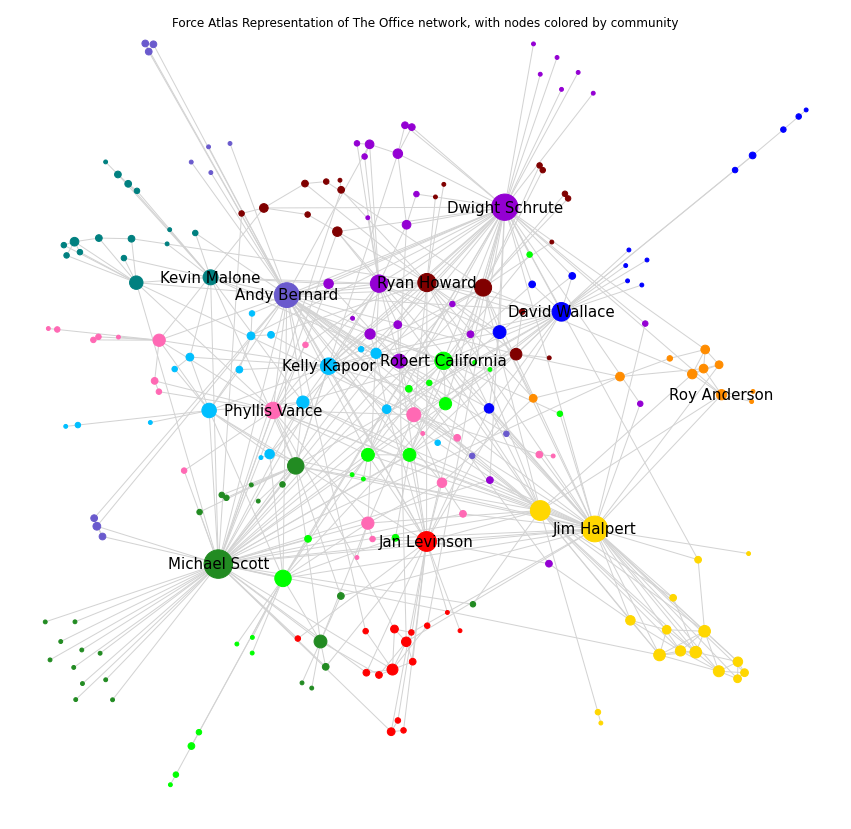

In [9]:
# plotting the network using networkx

plt.figure(figsize=(15, 15))
plt.title("Force Atlas Representation of The Office network, with nodes colored by community", c='black',  y=1.0, pad=-20)
d = dict(G.degree)
plt.axis('off') #This needs to be off, for the caption to be within the figure
caption = ''
nx.draw_networkx(G, positions, labels = labels, nodelist=list(d.keys()), node_size=[v*15 for v in d.values()], node_color = list(partition.values()), with_labels=True, edge_color='lightgrey', cmap=newcmp, font_size=15)
plt.show()